In [1]:
from roipoly import RoiPoly
import pickle
from matplotlib import pyplot as plt
import cv2, os
import numpy as np
from skimage.measure import label, regionprops
#%matplotlib notebook

In [55]:
pickle_in = open("barrel_blue","rb")
mask_list = pickle.load(pickle_in)
mask_array = np.asarray(mask_list)

In [63]:
def pre_training_process2(masks,train_size = 23):
    pixel_len = 1200*800
    sample_len = pixel_len*46
    x = np.ones([sample_len,7])
    y = np.zeros([sample_len,1])
    
    # randomly shuffle xtrain
    idx = np.asarray(range(46))
    #np.random.seed(1)
    np.random.shuffle(idx)  
    
    for i in range(46):
        img_name = str(idx[i]+1)+'.png'
        img = cv2.imread(os.path.join('trainset',img_name))
        img_new = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # convert to HSV color space
        img_flat = img_new.reshape(pixel_len,3)
        img_flat2 = img.reshape(pixel_len,3)
        x[i*pixel_len:(i+1)*pixel_len,:3] = img_flat
        x[i*pixel_len:(i+1)*pixel_len,3:6] = img_flat2
        labels = masks[i]
        y[i*pixel_len:(i+1)*pixel_len,0] = labels.reshape(pixel_len)

    train_num = train_size #number of samples used for training
    test_num = 46 - train_num
    x_train = x[:train_num*pixel_len]
    y_train = y[:train_num*pixel_len]
    x_test = x[train_num*pixel_len:]
    y_test = y[train_num*pixel_len:]
    return (x_train,y_train,x_test,y_test)

In [58]:
img = cv2.imread(os.path.join('trainset','1.png'))
img.shape

(800, 1200, 3)

In [279]:
x_train,y_train,x_test,y_test = pre_training_process2(mask_array)
w2 = lr2(x_train,y_train,x_test,y_test,0.05,50)

0.03152486413043478
0.021475860507246376
[[ 0.02123979]
 [ 0.00193431]
 [-0.94252275]
 [ 1.87792884]
 [-0.75684046]
 [-1.19629528]
 [ 0.35820218]]
0.03013582427536232
0.020175588768115944
[[ 0.00869943]
 [-0.03009278]
 [-0.94374209]
 [ 1.86623739]
 [-0.74429614]
 [-1.16433494]
 [ 0.35827393]]
0.02949981884057971
0.019422690217391306
[[ 7.92975092e-05]
 [-5.81875255e-02]
 [-9.41256730e-01]
 [ 1.85741121e+00]
 [-7.28423951e-01]
 [-1.12827445e+00]
 [ 3.58395980e-01]]
0.029127853260869564
0.018845335144927537
[[-0.0067286 ]
 [-0.08391962]
 [-0.9366656 ]
 [ 1.85043287]
 [-0.7109699 ]
 [-1.09063044]
 [ 0.35853911]]
0.02890461956521739
0.01832296195652174
[[-0.0124196 ]
 [-0.1080642 ]
 [-0.93086502]
 [ 1.84453083]
 [-0.69264301]
 [-1.05215614]
 [ 0.35869477]]
0.02874701086956522
0.017809329710144928
[[-0.01733324]
 [-0.13103646]
 [-0.92436393]
 [ 1.8392216 ]
 [-0.67379559]
 [-1.01313785]
 [ 0.35885937]]
0.028644927536231882
0.017461865942028986
[[-0.02165478]
 [-0.15305238]
 [-0.91748668]
 [ 

KeyboardInterrupt: 

In [427]:
 w = np.array([[-0.04979593]
 ,[-0.29959706]
 ,[-0.87621999]
 ,[ 1.78840066]
 ,[-0.52219075]
 ,[-0.69296174]
 ,[ 0.36030741]])

In [148]:
def err_rate2(x,y,w):
    result = np.dot(x,w)
    y_pred = (result>=0)
    err = np.sum(y_pred != y)/y.shape[0]
    return err


In [428]:
err_rate2(x_test,y_test,w2)

0.02989379528985507

In [429]:
err_rate2(x_train,y_train,w2)

0.03684560688405797

In [104]:
def predict(x,w):
    result = np.dot(x,w)
    y_pred = (result>=0)
    return y_pred

In [277]:
def grad(x,y,w):
    m = y.shape[0]
    z = y*np.dot(x, w) # dim(x_train) = sample_dim x 3 dim(w) = 3x1
    sig_z = 1 / (1+np.exp(-z))
    gradient =  np.sum(y*x*(1-sig_z),axis = 0).reshape(w.shape)
    gradient = gradient / np.linalg.norm(gradient)
    return gradient

def err_rate(x,y,w):
    result = np.dot(x,w)
    y_pred = (result>=0) * 2 - 1
    err = np.sum(y_pred != y)/y.shape[0]
    return err

def lr(x_train,y_train):
    step_size = 0.01
    max_iter = 50
    # initialize parameters w
    #w = np.random.randn(x_train.shape[1],1)
    w = np.array([[ 0.04176607],[ 0.03761931],[-0.93647226],[ 1.89223607],[-0.76342823],[-1.21911078],[ 0.35824075]])
    #w = np.array([[-0.07229567],[-0.05286705],[-0.08170436] ,[-0.47532825]])
    # change from (0,1) label to (-1,1)
    y_train = y_train * 2 - 1
    #y_test = y_test * 2 - 1
    err = 1
    iteration = 0
    #cost = cost(x_train,y_train,w)
    gradient = grad(x_train,y_train,w)
    #for i in range(max_iter):
    while iteration < max_iter and err > 0.001:
        #cost = cost(x_train,y_train,w)
        gradient = grad(x_train,y_train,w)
        w = w + step_size * gradient
        y_pred = predict(x_train,w)
        err = np.sum(y_pred != y_train)/y_train.shape[0]
        print(err)
        print(w)
        iteration += 1
    return w

def lr2(x_train,y_train,x_test,y_test,step_size = 0.1,max_iter = 50):
    alpha = step_size
    max_i = max_iter 
    # initialize parameters w
    #w = np.random.randn(x_train.shape[1],1)
    w = np.array([[ 0.04176607],[ 0.03761931],[-0.93647226],[ 1.89223607],[-0.76342823],[-1.21911078],[ 0.35824075]])
    
    # change from (0,1) label to (-1,1)
    y_train = y_train * 2 - 1
    y_test = y_test * 2 - 1
    err = 1
    iteration = 0
    #cost = cost(x_train,y_train,w)
    gradient = grad(x_train,y_train,w)
    #for i in range(max_iter):
    while iteration < max_i and err > 0.001:
        #cost = cost(x_train,y_train,w)
        gradient = grad(x_train,y_train,w)
        w = w + alpha * gradient
        err_train = err_rate(x_train,y_train,w)
        err_test = err_rate(x_test,y_test,w)
        print(err_train)
        print(err_test)
        print(w)
        iteration += 1
    return w    

In [424]:
def segment_image(img):
    pixel_len = img.shape[0] * img.shape[1]
    x = np.ones([pixel_len,7]) # 2 color spaces and bias term
    img_new = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # convert to HSV color space
    img_flat = img_new.reshape(pixel_len,3)
    img_flat2 = img.reshape(pixel_len,3)    
    x[:,:3] = img_flat
    x[:,3:6] = img_flat2
    w = np.array([[-0.08936352]
 ,[-0.3451944 ]
 ,[-0.91256014]
 ,[ 1.63474669]
 ,[-0.40552046]
 ,[-0.39398803]
 ,[ 0.362268  ]])
    result = np.dot(x,w)
    y_pred = (result>=0)
    mask_img = y_pred.reshape(img.shape[0],img.shape[1]) # reshape back to 2D image dimensions
    return mask_img


In [ ]:
w = np.array([[-0.08936352]
 ,[-0.3451944 ]
 ,[-0.91256014]
 ,[ 1.63474669]
 ,[-0.40552046]
 ,[-0.39398803]
 ,[ 0.362268  ]])

In [422]:
(np.dot(x,w2)>0).sum()

17949

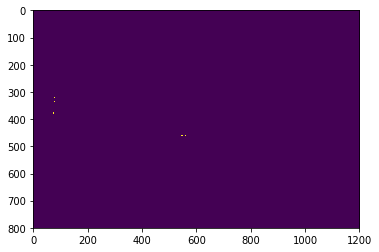

In [425]:
img = cv2.imread(os.path.join('trainset','5.png'))
mas = segment_image(img)
plt.imshow(mas)

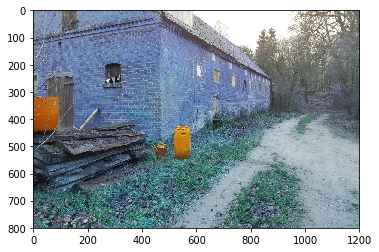

In [319]:
plt.imshow(img)

In [ ]:
def get_contour(mask):
    new_mask = erode_dilate(mask,10,1)
    typed_mask = new_mask.astype('uint8')
    contours, hiearchy = cv2.findContours(typed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [113]:
def erode_dilate(mask,e_kernel = 5,d_kernel = 5,e_iter = 1 ,d_iter = 1):
    kernel_e = np.ones((e_kernel,e_kernel), np.uint8)
    kernel_d = np.ones((d_kernel,d_kernel), np.uint8)
    img_erosion = cv2.erode(mask, kernel_e, iterations = e_iter) 
    img_dilation = cv2.dilate(img_erosion, kernel_d, iterations = d_iter)
    return img_dilation

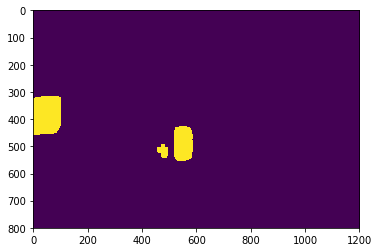

In [320]:
mas_t = mas.astype('uint8')
res = erode_dilate(mas_t,2,4,2,5)
plt.imshow(res) 
plt.show()

In [ ]:
def normalized_l2(prop):
    x1,y1,x2,y2 = prop.bbox
    b = x2 - x1
    h = y2 -y1
    loc_x,loc_y = prop.local_centroid
    bb_x = b/2
    bb_y = h/2
    l2_dist= ((loc_x-bb_x)/b)**2+((loc_y-bb_y)/h)**2 #normalized
    res = 1-np.sqrt(l2_dist)
    return res

In [ ]:
def process_props(contours):
    #get all props from contours
    all_props = []
    for c in contours:
        cc = cv2.drawContours(np.zeros([800,1200]), [c], 0, (255,0,0), 2)
        c_region = cc.astype('int32')
        props = regionprops(c_region)
        all_props.append(props)
    # sort props
    prop_sort = np.zeros([len(contours),4])
    for i in range(len(contours)):
        c_prop = all_props[i][0]
        area = c_prop.filled_area
        r_area = c_prop.filled_area/c_prop.bbox_area
        n_L2 = normalized_l2(c_prop)
        prop_sort[i,0] = area
        prop_sort[i,1] = r_area
        prop_sort[i,2] = n_L2
        prop_sort[i,3] = i 
        Ars = -prop_sort[:,0]
        idxs = Ars.argsort()
    sorted_prop = prop_sort[idxs]
    top5_area = sorted_prop[:5] 
    result = []
    bboxs = []
    max_area = top5_area[0][0]
    for i in range(top5_area.shape[0]):
        target = top5_area[i]
        orig_idx = int(target[3])
        if target[0] >= 0.3*max_area and target[1] >= 0.7 and target[2] >= 0.93: #area percentage >0.7 and l2 >= 0.93
            result.append(target)
            bboxs.append(all_props[orig_idx][0].bbox)
    return result,bboxs

In [ ]:
cprop,bb = process_props(contours)
cprop

In [ ]:
print(prop_sort[0])
a = prop_sort[:,0]
b = a.argsort()
print(prop_sort[0])
print(b)

In [ ]:
print(big.filled_area)#/big.bbox_area)

In [ ]:
loc_x,loc_y = big.local_centroid
x1,y1,x2,y2 = big.bbox
peri_c = 2 * (loc_x +loc_y)
peri = (x2-x1+y2-y1)*2
r_p = peri_c / peri 
area_c = 4 * loc_x * loc_y
area = big.convex_area
r_a = area / big.bbox_area
print(r_p, r_a)

In [ ]:
big.bbox

In [ ]:
xy = big.coords
cent = big.centroid
(xy-cent).sum()

In [ ]:
print(big.moments_central)

In [ ]:
plt.imshow(big.filled_image)

In [ ]:
big.local_centroid

In [ ]:
ttt = cc.astype('int32')
props = regionprops(c_region)


In [ ]:
l = label(cc, connectivity=cc.ndim)

In [ ]:
l.shape

In [ ]:
plt.imshow(l)

In [ ]:
l[600][600]

In [ ]:
test = np.zeros([7,7])
test[3:6,3] = 1
test[3:6,5] = 1
test[3,4] = 1
test[5,4] = 1
yy = test.astype('uint8')

In [238]:
contours, hiearchy = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [211]:
len(contours)

12

In [239]:
cc = cv2.drawContours(img, boxes, -1, (255,0,0), 3)
plt.imshow(cc)

TypeError: contours is not a numpy array, neither a scalar

In [631]:
class BarrelDetector():
    def __init__(self):
        '''
        Initilize your blue barrel detector with the attributes you need
        eg. parameters of your classifier
        '''
    def segment_image(self, img):
        '''
        Calculate the segmented image using a classifier
        eg. Single Gaussian, Gaussian Mixture, or Logistic Regression
        call other functions in this class if needed
        Inputs:
        img - original image
        Outputs:
        mask_img - a binary image with 1 if the pixel in the original image is blue and 0 otherwise
        '''
        pixel_len = img.shape[0] * img.shape[1]
        x = np.ones([pixel_len,7]) # 2 color spaces and bias term
        img_new = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # convert to HSV color space
        img_flat = img_new.reshape(pixel_len,3)
        img_flat2 = img.reshape(pixel_len,3)    
        x[:,:3] = img_flat # feature 1-3 are HSV values
        x[:,3:6] = img_flat2 # FEATURE 4-6 are BGR values
        # import trained weights for classification
        w = np.array([[-0.0067286 ],[-0.08391962],[-0.9366656 ],[ 1.85043287],[-0.7109699 ],[-1.09063044],[ 0.35853911]])
        result = np.dot(x,w) # obtain prediction results with (-1,1) labels
        y_pred = (result>=0)
        mask_img = y_pred.reshape(img.shape[0],img.shape[1]) # reshape back to 2D image dimensions
        new_mask = mask_img.astype('uint8')
        return new_mask

    def get_bounding_box(self, img):
        '''
        Find the bounding box of the blue barrel
        call other functions in this class if needed
        Inputs:
        img - original image
        Outputs:
        boxes - a list of lists of bounding boxes. Each nested list is a bounding box in the form of [x1, y1, x2, y2] 
        where (x1, y1) and (x2, y2) are the top left and bottom right coordinate respectively. The order of bounding boxes in the list is from left to right in the image.
        '''
        mask_img = self.segment_image(img) # get masked image using segment function from above
        contours = get_contour(mask_img) # get processed contours from the masks
        cprop, boxes = process_props(contours) # get bounding boxes
        return boxes
    
def erode_dilate(mask,e_kernel = 2,d_kernel = 10,e_iter = 5 ,d_iter = 5):
    ''' Erode and dilate the mask image to reduce noise and combine segmented regions'''
    kernel_e = np.ones((e_kernel,e_kernel), np.uint8)
    kernel_d = np.ones((d_kernel,d_kernel), np.uint8)
    img_erosion = cv2.erode(mask, kernel_e, iterations = e_iter) 
    img_dilation = cv2.dilate(img_erosion, kernel_d, iterations = d_iter)
    return img_dilation
    
def get_contour(mask):
    '''Apply the erosion and dilation, and generate contours from the processed masks'''
    new_mask = erode_dilate(mask,2,5,2,5)
    contours, hiearchy = cv2.findContours(new_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def normalized_l2(prop):
    ''' Calculate the normalized L2 deviation of contours' centroids from the center of bounding boxes''' 
    x1,y1,x2,y2 = prop.bbox
    b = x2 - x1 # base length
    h = y2 -y1 # height
    loc_x,loc_y = prop.local_centroid
    bb_x = b/2 # bbox center x
    bb_y = h/2 # bbox center y
    l2_dist= ((loc_x-bb_x)/b)**2+((loc_y-bb_y)/h)**2 # calculate distance
    res = 1-np.sqrt(l2_dist) # calculate score
    return res

def process_props(contours):
    '''Obtain properties of contours'''
    all_props = []
    for c in contours:
        cc = cv2.drawContours(np.zeros([800,1200]), [c], 0, (255,0,0), 2)
        c_region = cc.astype('int32')
        props = regionprops(c_region)
        all_props.append(props)
    # sort props
    prop_sort = np.zeros([len(contours),4])
    for i in range(len(contours)):
        c_prop = all_props[i][0]
        area = c_prop.filled_area # filled contour area
        r_area = c_prop.filled_area/c_prop.bbox_area # area ratio between filled and bbox
        n_L2 = normalized_l2(c_prop) # distance from center
        prop_sort[i,0] = area
        prop_sort[i,1] = r_area
        prop_sort[i,2] = n_L2
        prop_sort[i,3] = i 
        Ars = -prop_sort[:,0] # sort aacording to filled area
        idxs = Ars.argsort() 
    sorted_prop = prop_sort[idxs]
    top_area = sorted_prop[:3] # get bbox of top 3 areas 
    result = []
    bboxs = []
    for i in range(top_area.shape[0]):
        target = top_area[i]
        orig_idx = int(target[3])
        if target[1] >= 0.75 and target[2] >= 0.94: # filter by area ratio >0.75 and l2 >= 0.94
            result.append(target)
            y1,x1,y2,x2 = all_props[orig_idx][0].bbox
            if max((x2-x1)/(y2-y1), (y2-y1)/(x2-x1)) < 2:
                bboxs.append([x1,y1,x2,y2])
    return result,bboxs    


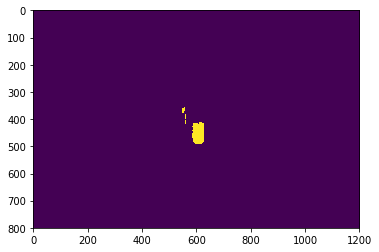

In [647]:
my_detector = BarrelDetector()
img = cv2.imread(os.path.join('trainset','46.png'))
mask_img = my_detector.segment_image(img)
plt.imshow(mask_img)

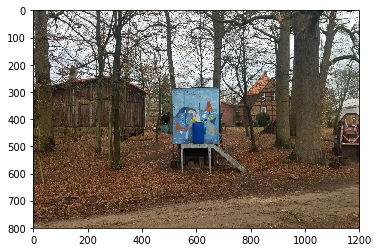

In [648]:
plt.imshow(cv_conv(img))

In [649]:
boxes = my_detector.get_bounding_box(img)

In [650]:
boxes

[[576, 403, 639, 503], [538, 348, 570, 387]]

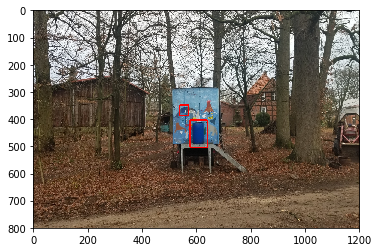

In [651]:
for box in boxes:
    x1,y1,x2,y2 = box
    cv2.rectangle(img,(x1,y1),(x2,y2),(0,0,255),4)
plt.imshow(cv_conv(img))

In [652]:
def cv_conv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
 w = np.array([[-0.08936352]
 ,[-0.3451944 ]
 ,[-0.91256014]
 ,[ 1.63474669]
 ,[-0.40552046]
 ,[-0.39398803]
 ,[ 0.362268  ]])